# Apply PeLEE Selection to NTuples

In [1]:
import sys
import localSettings as ls
import os
print(ls.main_path)

/Users/davidc-local/data/searchingfornues/v08_00_00_48/


In [2]:
main_path = ls.main_path
sys.path.append(main_path)

In [3]:
from datetime import datetime
now = datetime.now()
date_time = now.strftime("%m%d%Y")
print("date and time:",date_time)

date and time: 02152021


In [4]:
from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    norm = A/(np.sqrt(2*np.pi)*sigma)
    exp  = np.exp(-((x-mu)**2)/(2*sigma*sigma))
    return norm * exp

In [5]:
import plotter
import importlib
importlib.reload(plotter)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
#if USEBDT:
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward
import pandas as pd

params = {
    'axes.labelsize': 'x-large',
    'axes.titlesize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large'
}
pylab.rcParams.update(params)

### import module responsible for loading NTuples

In [7]:
import load_data_run123

In [8]:
PATH = '/Users/davidc-local/data/searchingfornues/v08_00_00_48//run1/noweights/'
FILE = 'prodgenie_bnb_intrinsice_nue_uboone_overlay_mcc9.1_v08_00_00_26_run1_reco2_reco2.root'

In [9]:
fold = 'nuselection'
tree = 'NeutrinoSelectionFilter'

In [10]:
VARDICT = load_data_run123.get_variables()

### Load variables needed to apply selections & plot distributions

In [11]:
variables = VARDICT['VARIABLES'] + VARDICT['NUEVARS']

In [12]:
variables += ['elec_e','truthFiducial','weightSplineTimesTune','proton_e','leeweight','elec_pz']

In [13]:
variables = list(set(variables))

### Load Pandas DataFrame with NTuple contents

In [14]:
up = uproot.open(PATH+FILE)[fold][tree]
df = up.pandas.df(variables, flatten=False)

### Load variables from Pandas DataFrame

In [15]:
load_data_run123.process_uproot(up,df)

### Set dummy variables for BNB/EXT data fields 

In [16]:
df['bnbdata']  = np.zeros_like(df['nslice'])
df['extdata']  = np.zeros_like(df['nslice'])

### Function to calculate efficiency:

In [17]:
def Eff(df,var,query,acceptance,bin_edges,absval=False):
    #print acceptance
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    num_v = []
    den_v = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = '%s > %f and %s < %f'%(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        if (acceptance != ''): bincut += ' and %s'%acceptance
        #print bincut
        df_tmp =  df.query(bincut) # cut on bin range for desired var.
        df_sub = df_tmp.query(query) # apply constrain 
        if (df_tmp.shape[0] == 0): continue
        num_v.append(df_sub.shape[0])
        den_v.append(df_tmp.shape[0])
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
        #print 'eff = %.02f @ bin = %.02f'%(eff,bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err),np.array(num_v),np.array(den_v)

### various functions to perform gaussian fits

In [18]:
import scipy.optimize

def gauss_exp(x, n, mu, sigma, k):
    sigma = abs(sigma)
    condition = (x - mu) / sigma >= -k    
    y = np.copy(x)
    y[condition] = n * np.exp(-0.5 * ((x[condition] - mu) / sigma)**2)
    y[~condition] = n * np.exp(k**2 / 2 + k * ((x[~condition] - mu) / sigma))
#     print(x)
    return y

def get_function_max(f, *args):
    def func(x, *arg):
        return -f(x, *arg)
    return f(scipy.optimize.fmin(func, 0, args=args, disp=False)[0], *args)

def find_nearest(array, value):
    array = np.asarray(array)
    #print (array)
    idx = (np.abs(array - value)).argmin()
    return idx

def mpv(array):
    if sum(array) < 5:
        return np.median(array)
    
    n_bins = energy_bins
    r = energy_range
    hist, bin_edges = np.histogram(array, bins=n_bins, range=r)
    
    bin_centers = [i*r[1]/n_bins-r[1]/(n_bins*2) for i in range(1,n_bins+1)]
    try:
        popt, pcov = scipy.optimize.curve_fit(gauss_exp, bin_centers, hist, maxfev=10000)
        return scipy.optimize.fmin(lambda x: -gauss_exp(x, *popt), 0)
    except RuntimeError:
        return np.median(array)
    
def fwhm(array):
    if sum(array) < 5:
        return np.std(array)

    n_bins = energy_bins
    r = energy_range
    hist, bin_edges = np.histogram(array, bins=n_bins, range=r)
    
    bin_centers = [i*r[1]/n_bins-r[1]/(n_bins*2) for i in range(1,n_bins+1)]

    try:
        popt, pcov = scipy.optimize.curve_fit(gauss_exp, bin_centers, hist, maxfev=10000)
        x_values = np.linspace(r[0], r[1], 1000)
        y_values = gauss_exp(np.linspace(r[0], r[1], 1000), *popt)
        try:
            x_max = scipy.optimize.fmin(lambda x: -gauss_exp(x, *popt), 0)
        except RuntimeError:
            x_max = np.median(array)
        y_max = find_nearest(y_values, gauss_exp(x_max, *popt))
        y_max_value = y_values[y_max]
        fwhm1 = find_nearest(y_values[:y_max], y_max_value/2)
        fwhm2 = find_nearest(y_values[y_max:], y_max_value/2)
        x_2 = x_values[y_max:][fwhm2]     
        x_1 = x_values[:y_max][fwhm1]
        return x_2-x_1
    except RuntimeError:
        return np.std(array)

### Load variables needed to apply BDT 

In [19]:
TRAINVAR = ["shr_score","tksh_distance","tksh_angle",
            "shr_tkfit_dedx_max",
            "trkfit","trkpid",
            "subcluster","shrmoliereavg",
            "trkshrhitdist2","hits_ratio",
            "secondshower_Y_nhit","secondshower_Y_vtxdist","secondshower_Y_dot","anglediff_Y",
            "CosmicIPAll3D","CosmicDirAll3D"]

LABELS =  ['pi0','nonpi0']

TRAINVARZP = ['shrmoliereavg','shr_score', "trkfit","subcluster",
              "CosmicIPAll3D","CosmicDirAll3D",
              'secondshower_Y_nhit','secondshower_Y_vtxdist','secondshower_Y_dot','anglediff_Y',
              'secondshower_V_nhit','secondshower_V_vtxdist','secondshower_V_dot','anglediff_V',
              'secondshower_U_nhit','secondshower_U_vtxdist','secondshower_U_dot','anglediff_U',
              "shr_tkfit_2cm_dedx_U", "shr_tkfit_2cm_dedx_V", "shr_tkfit_2cm_dedx_Y",
              "shr_tkfit_gap10_dedx_U", "shr_tkfit_gap10_dedx_V", "shr_tkfit_gap10_dedx_Y",
              "shrMCSMom","DeltaRMS2h","shrPCA1CMed_5cm","CylFrac2h_1cm"]

LABELSZP = ['bkg']

def loadBDT(DF):

    for label, bkg_query in zip(LABELS, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            DF[label+"_score"] = booster.predict(xgb.DMatrix(DF[TRAINVAR]),
                                                 ntree_limit=booster.best_iteration)

    for label, bkg_query in zip(LABELSZP, nue_booster.bkg_queries):
        with open(ls.pickle_path+'booster_%s_0304_extnumi_vx.pickle' % label, 'rb') as booster_file:
            booster = pickle.load(booster_file)
            DF[label+"_score"] = booster.predict(xgb.DMatrix(DF[TRAINVARZP]),
                                                 ntree_limit=booster.best_iteration)
            
    return

### Compute additional variables for nue selection not stored directly in NTuples

In [22]:
INTERCEPT = 0.0
SLOPE = 0.83

df['subcluster'] = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
df['trkfit'] = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
df['anglediff_Y'] = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
df['anglediff_V'] = np.abs(df['secondshower_V_dir']-df['shrclusdir1'])
df['anglediff_U'] = np.abs(df['secondshower_U_dir']-df['shrclusdir0'])                                                                                                                       
df["ptOverP"] = df["pt"]/df["p"]
df["phi1MinusPhi2"] = df["shr_phi"]-df["trk_phi"]
df["theta1PlusTheta2"] = df["shr_theta"]+df["trk_theta"]
df['cos_shr_theta'] = np.cos(df['shr_theta'])
df['shr_tkfit_nhits_tot'] = (df['shr_tkfit_nhits_Y']+df['shr_tkfit_nhits_U']+df['shr_tkfit_nhits_V'])                                                                                                                                                                                              
df['shr_tkfit_2cm_nhits_tot'] = (df['shr_tkfit_2cm_nhits_Y']+df['shr_tkfit_2cm_nhits_U']+df['shr_tkfit_2cm_nhits_V'])                                                                                                                                                              
df['shr_tkfit_gap10_nhits_tot'] = (df['shr_tkfit_gap10_nhits_Y']+df['shr_tkfit_gap10_nhits_U']+df['shr_tkfit_gap10_nhits_V'])                                                                                                                             
df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
#df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_U']
#df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_V']
df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
df['electron_e'] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE

loadBDT(df)

### load pre-determined selections for PeLEE nue/numu cut-flows

In [23]:
import unblinding_far_sideband

### 1eNp BDT selection

In [40]:
QUERYNPBDT = unblinding_far_sideband.NPPRESQ + ' and ' + unblinding_far_sideband.BDTCQ

### correct GENIE weights for unphysical values

In [24]:
df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.

### import matplotlib for simple plotting

In [26]:
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

plt.rcParams.update({'font.size': 16})

### Truth-based plot: split by true final-state (0pi, 0pi0p, 0piNp)

In [31]:
dfsub = df.query('(nu_pdg == 12 or nu_pdg == -12) and isVtxInFiducial == 1')

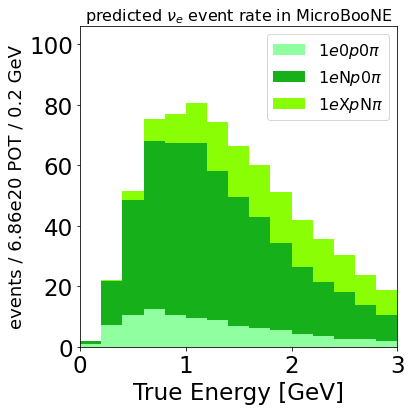

In [34]:
df1eNp0pi = dfsub.query('nproton > 0 and npion == 0')
df1e0p0pi = dfsub.query('nproton == 0 and npion == 0')
df1eXpNpi = dfsub.query('npion > 0')

fig = plt.figure(figsize=(6,6))
BINS = np.linspace(0.,3.0,16)
SAMPLE = r'$\nu_{\mu}$'

POTTOT = 7.75e22 # This number should be the POT of the MC Sample

vals = dfsub['nu_e']
vals1eNp0pi = df1eNp0pi['nu_e']
vals1e0p0pi = df1e0p0pi['nu_e']
vals1eXpNpi = df1eXpNpi['nu_e']

weights = dfsub['weightSplineTimesTune'] * (6.86e20 / POTTOT)
weights1eNp0pi = df1eNp0pi['weightSplineTimesTune'] * (6.86e20 / POTTOT)
weights1e0p0pi = df1e0p0pi['weightSplineTimesTune'] * (6.86e20 / POTTOT)
weights1eXpNpi = df1eXpNpi['weightSplineTimesTune'] * (6.86e20 / POTTOT)
weightsLEE = weights * dfsub['leeweight']

plt.hist([vals1e0p0pi,vals1eNp0pi,vals1eXpNpi],bins=BINS,\
         weights=[weights1e0p0pi,weights1eNp0pi,weights1eXpNpi],\
         label=['1$e$0$p$0$\pi$','1$e$N$p$0$\pi$','1$e$X$p$N$\pi$'],
         color=['xkcd:mint green','xkcd:green','xkcd:lime green'],stacked=True)

lee_tot = np.concatenate([vals,vals])
lee_weights_tot = np.concatenate([weights,weightsLEE])

plt.xlabel(r'True Energy [GeV]')
plt.ylabel('events / 6.86e20 POT / 0.2 GeV',fontsize=18)
plt.legend(loc=1)
plt.xlim([0,3.0])
plt.ylim(0., plt.gca().get_ylim()[1]*1.25)
plt.title(r'predicted $\nu_e$ event rate in MicroBooNE',fontsize=16)
plt.tight_layout()
plt.show()

# Energy Resolution

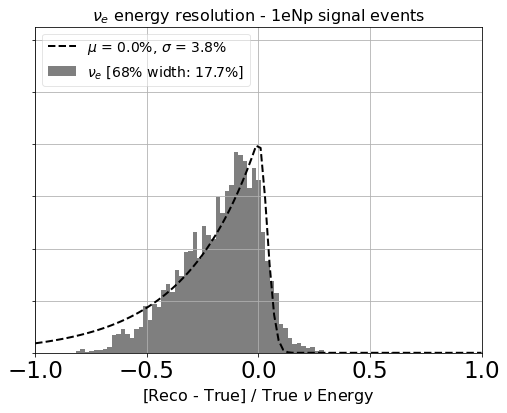

In [52]:
fig = plt.figure(figsize=(8,6))
START = 0.0
B = np.linspace(-1,1,100)
XBINS = np.linspace(B[0],B[-1],100)

# Apply 1eNp BDT selection
dfsub = df.query(QUERYNPBDT + ' and nproton > 0 and npion == 0')

dfsub_QE = dfsub.query('interaction == 0')
dfsub_MEC = dfsub.query('interaction == 10')
dfsub_OTR = dfsub.query('interaction != 0 and interaction != 10')

#RECOVAR = 'neutrino_energy'
RECOVAR = 'reco_e'
#TRUEVAR = 'true_e_visible'
TRUEVAR = 'nu_e'
MASS = 0.00

PART = '$\\nu_{e}$'

var_ALL_v = (dfsub[RECOVAR] - (dfsub[TRUEVAR] + MASS)) / (dfsub[TRUEVAR] + MASS)
var_QE_v = (dfsub_QE[RECOVAR] - (dfsub_QE[TRUEVAR] + MASS) ) / (dfsub_QE[TRUEVAR] + MASS)
var_MEC_v = (dfsub_MEC[RECOVAR] - (dfsub_MEC[TRUEVAR] + MASS) ) / (dfsub_MEC[TRUEVAR] + MASS)
var_OTR_v = (dfsub_OTR[RECOVAR] - (dfsub_OTR[TRUEVAR] + MASS) ) / (dfsub_OTR[TRUEVAR] + MASS)

quantile_med = np.quantile(var_ALL_v,0.5)
quantile_up  = np.quantile(var_ALL_v,0.5+0.34)
quantile_dn  = np.quantile(var_ALL_v,0.5-0.34)
quantile_ALL_res = (quantile_up-quantile_dn)/2.

quantile_med = np.quantile(var_QE_v,0.5)
quantile_up  = np.quantile(var_QE_v,0.5+0.34)
quantile_dn  = np.quantile(var_QE_v,0.5-0.34)
quantile_QE_res = (quantile_up-quantile_dn)/2.

# ALL
vals,binedges,s = plt.hist(var_ALL_v ,bins=B,histtype='stepfilled',lw=2,alpha=0.5,\
                           label=r'%s [68%% width: %.01f%%]'%(PART,100.*quantile_ALL_res),color='k')
bincenters = 0.5*(binedges[1:]+binedges[:-1])
popt, pcov = scipy.optimize.curve_fit(gauss_exp, bincenters, vals, maxfev=10000,\
                                      p0=[np.max(vals),0.0,0.2,0.1],
                                     bounds=([0,0,0,0],[1e4,0.1,0.2,1.0]))
plt.plot(XBINS,gauss_exp(XBINS,*popt),'--',color='k',lw=2,\
         label='$\mu$ = %.01f%%, $\sigma$ = %.01f%%'%(100.*popt[1],100.*popt[2]))

plt.title(r'$\nu_{e}$ energy resolution - 1eNp signal events',fontsize=16)

plt.xlabel(r'[Reco - True] / True $\nu$ Energy',fontsize=16)
plt.grid()
#plt.ylim([0,1.2])
plt.xlim([-1,1])
plt.gca().set_yticklabels([])
plt.legend(loc=2,fontsize=14,framealpha=0.5)
plt.ylim(0, plt.gca().get_ylim()[1]*1.5)
#plt.yscale('log')
#plt.title(r'v08_00_00_26 Run1 Samples')
#plt.legend(loc=7,fontsize=14)
plt.show()

# Efficiency

query...
acceptance...
isVtxInFiducial == 1 and truthFiducial == 1 and ccnc>=0 and npi0==0 and npion==0


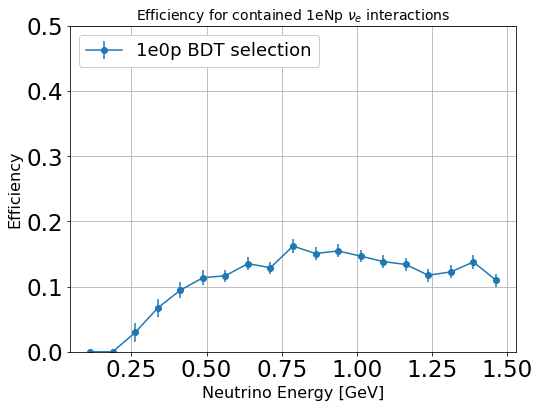

In [59]:
fig = plt.figure(figsize=(8,6))
START = 0.
B = np.linspace(0.15,1.55,1)
VAR = 'nu_e' 

ACCEPTANCE = 'isVtxInFiducial == 1 and truthFiducial == 1 and ccnc>=0 and npi0==0 and npion==0'
ACCEPTANCENP = ACCEPTANCE + ' and nproton > 0'

num_v = []
den_v = []

centers,vals,errs,num_v,den_v = Eff(df,VAR,QUERYNPBDT,ACCEPTANCENP,B)
plt.errorbar(centers-START,vals,yerr=errs,fmt='o-',label=r'1e0p BDT selection')

print ('query...')
print ('acceptance...')
print (ACCEPTANCE)

plt.xlabel(r'Neutrino Energy [GeV]',fontsize=16)
plt.ylabel(r'Efficiency',fontsize=16)
plt.title(r'Efficiency for contained 1eNp $\nu_e$ interactions',fontsize=14)
plt.grid()
plt.ylim([0,0.5])
plt.legend(loc=2,fontsize=18,framealpha=1.0)
plt.show()